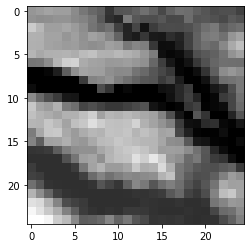

In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

# Load the terrain
terrain = imread('data/SRTM_data_Norway_1.tif')

z = terrain[2000:2500:20, 500:1000:20]
z -= np.min(z)
z = z / np.max(z)

plt.imshow(z, cmap='gray')

x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

# X = np.c_[x.reshape(-1, 1), y.reshape(-1, 1)]

In [2]:
def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X[:, 1:]

X = create_X(x, y, 10)

In [28]:
X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), test_size=0.3)

model = LinearRegression()
model.fit(X_train, z_train)
z_tilde = model.predict(X_train)
z_pred = model.predict(X_test)

z_pred -= np.min(z_pred)
z_pred = z_pred / np.max(z_pred)

Test R2:   0.7561045951882928
Test MSE:  0.016440352908720618


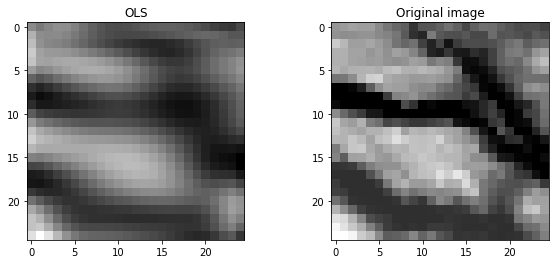

In [29]:
print("Test R2:   {}".format(r2_score(z_test, z_pred)))
print("Test MSE:  {}".format(mean_squared_error(z_test, z_pred)))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('OLS')
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

In [31]:
X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), test_size=0.3)

model = SGDRegressor(max_iter = 1000, eta0=0.01)
model.fit(X_train, z_train.ravel())
z_tilde = model.predict(X_train)
z_pred = model.predict(X_test)

z_pred -= np.min(z_pred)
z_pred = z_pred / np.max(z_pred)

print(np.min(z), np.max(z))
print(np.min(z_pred), np.max(z_pred))

0.0 1.0
0.0 1.0


Test R2:   0.023475485756319525
Test MSE:  0.11739050671570919


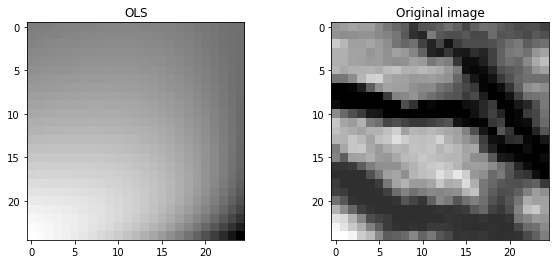

In [32]:
print("Test R2:   {}".format(r2_score(z_train, z_tilde)))
print("Test MSE:  {}".format(mean_squared_error(z_test, z_pred)))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('OLS')
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

In [36]:
n_epochs = 10000
m = 125
M = 5

def SGD_linreg(X, y, n_epochs, batch_size, eta):
    datapoints = X.shape[0]
    beta = np.random.randn(X.shape[1], 1)
    for epoch in range(n_epochs):
        perm = np.random.permutation(datapoints)
        X_shuffled = X[perm, :]
        y_shuffled = y[perm, :]
        for i in range(0, datapoints, batch_size):
            gradient = (2 / batch_size) * X_shuffled.T @ ((X_shuffled @ beta) - y_shuffled)
            beta = beta - gradient * eta
    return beta

beta = SGD_linreg(X_train, z_train, 10000, 1000, 0.05)

print(np.min(z), np.max(z))
print(np.min(z_pred), np.max(z_pred))

0.0 1.0
0.0 1.0


Test R2:   0.10464393181367337
Test MSE:  0.05186115071389775


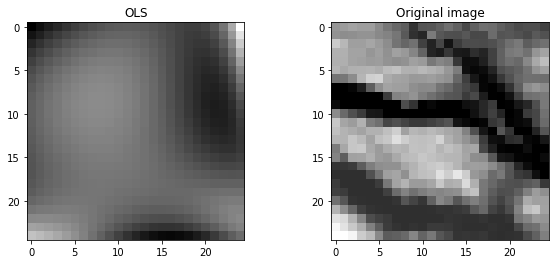

In [37]:
pred_img = (X @ beta).reshape(z.shape)
print("Test R2:   {}".format(r2_score(z_test, X_test @ beta)))
print("Test MSE:  {}".format(mean_squared_error(z_test, X_test @ beta)))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pred_img, cmap='gray')
ax1.set_title('OLS')
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

In [24]:
n = 10

rates = np.logspace(-3, -1, n)
test_mse = np.zeros(n)
test_r2 = np.zeros(n)

j = 0
for i in rates:
    betas = SGD_linreg(X_train, z_train, 1000, 1000, i)
    pred = X_test @ betas
    # reg = SGDRegressor(eta0=i)
    # reg.fit(X_train, z_train)
    # pred = reg.predict(X_test)
    test_mse[j] = mean_squared_error(z_test, pred)
    test_r2[j] = r2_score(z_test, pred)
    j += 1

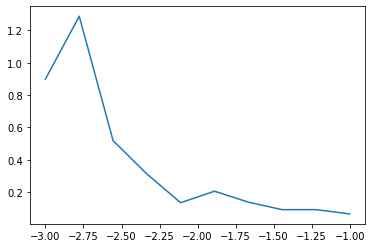

In [25]:
plt.plot(np.log10(rates), test_mse)

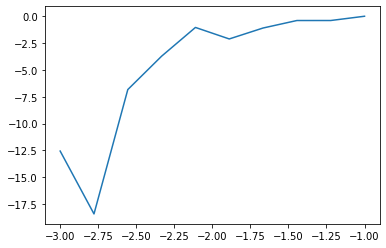

In [26]:
plt.plot(np.log10(rates), test_r2)